In [1]:
%load_ext autoreload
%autoreload 2

# Définition du seuil

source: [Fine tuning the threshold in face recognition](https://sefiks.com/2020/05/22/fine-tuning-the-threshold-in-face-recognition/)

## Génération des identitées

In [2]:
import os
import pandas as pd
import itertools
import cv2
from chefboost import Chefboost as chef
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from matplotlib import pyplot as plt

current_dir = os.getcwd()
new_dir = current_dir.replace("\\tests", "")
os.chdir(new_dir)

from services.faces.face_detector import FaceDetector
from services.faces.comparators.yolo_comparator import YoloComparator
from services.images.image_editor import ImageEditor

In [3]:
dataset_root = "training\\classifier\\dataset\\val"

def get_person_files(dataset_root) -> dict:
    person_files = {}

    for root, dirs, files in os.walk(dataset_root):
        for dir in dirs:
            person_name = dir
            person_dir = os.path.join(root, dir)
            person_files[person_name] = []

            for file in os.listdir(person_dir):
                if file.endswith(".jpg"):
                    person_files[person_name].append(dir + '\\' + file)

    return person_files

identities = get_person_files(dataset_root)

print(identities)

{'Angelina Jolie': ['Angelina Jolie\\018_fcafe1a8.jpg', 'Angelina Jolie\\022_b497b92e.jpg', 'Angelina Jolie\\037_62d00a09.jpg', 'Angelina Jolie\\045_c560251e.jpg', 'Angelina Jolie\\050_7c5b026c.jpg', 'Angelina Jolie\\084_da751ddd.jpg', 'Angelina Jolie\\087_f325890f.jpg', 'Angelina Jolie\\090_da55509f.jpg', 'Angelina Jolie\\092_26130bb1.jpg', 'Angelina Jolie\\095_0be163a1.jpg'], 'Brad Pitt': ['Brad Pitt\\012_8de7a736.jpg', 'Brad Pitt\\014_871b0d80.jpg', 'Brad Pitt\\017_4748675b.jpg', 'Brad Pitt\\030_716e4856.jpg', 'Brad Pitt\\045_6895fe7e.jpg', 'Brad Pitt\\053_be062c12.jpg', 'Brad Pitt\\056_8362ff51.jpg', 'Brad Pitt\\065_34848907.jpg'], 'Denzel Washington': ['Denzel Washington\\013_5928728c.jpg', 'Denzel Washington\\014_9742cf0f.jpg', 'Denzel Washington\\023_75fd6b60.jpg', 'Denzel Washington\\047_05f6a63f.jpg', 'Denzel Washington\\051_d27cd673.jpg', 'Denzel Washington\\057_ce4bc775.jpg', 'Denzel Washington\\071_30155b02.jpg', 'Denzel Washington\\092_8f204d71.jpg', 'Denzel Washington\\09

## Génération de paires positives

In [4]:
positives = []
for key, values in identities.items():
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            positives.append([values[i], values[j]])

positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

positives

,file_x,file_y,decision
0,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\022_b497b92e.jpg,Yes
1,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\037_62d00a09.jpg,Yes
2,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\045_c560251e.jpg,Yes
3,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\050_7c5b026c.jpg,Yes
4,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\084_da751ddd.jpg,Yes
...,...,...,...
731,Will Smith\051_1f3aede9.jpg,Will Smith\072_4a17b7fb.jpg,Yes
732,Will Smith\051_1f3aede9.jpg,Will Smith\087_6eba84a6.jpg,Yes
733,Will Smith\053_8405b30f.jpg,Will Smith\072_4a17b7fb.jpg,Yes
734,Will Smith\053_8405b30f.jpg,Will Smith\087_6eba84a6.jpg,Yes


## Génération de paires négatives

In [5]:
samples_list = list(identities.values())

negatives = []
for i in range(0, len(identities) - 1):
    for j in range(i+1, len(identities)):
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)

    for cross_sample in cross_product:
        negatives.append([cross_sample[0], cross_sample[1]])

negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

negatives

,file_x,file_y,decision
0,Angelina Jolie\018_fcafe1a8.jpg,Will Smith\008_cdaf39e7.jpg,No
1,Angelina Jolie\018_fcafe1a8.jpg,Will Smith\021_3cf2aa92.jpg,No
2,Angelina Jolie\018_fcafe1a8.jpg,Will Smith\030_df8c8fad.jpg,No
3,Angelina Jolie\018_fcafe1a8.jpg,Will Smith\046_6d5b1ed6.jpg,No
4,Angelina Jolie\018_fcafe1a8.jpg,Will Smith\051_1f3aede9.jpg,No
...,...,...,...
1243,Tom Hanks\097_0c9b7ced.jpg,Will Smith\046_6d5b1ed6.jpg,No
1244,Tom Hanks\097_0c9b7ced.jpg,Will Smith\051_1f3aede9.jpg,No
1245,Tom Hanks\097_0c9b7ced.jpg,Will Smith\053_8405b30f.jpg,No
1246,Tom Hanks\097_0c9b7ced.jpg,Will Smith\072_4a17b7fb.jpg,No


## Merge pairs

In [6]:
df = pd.concat([positives, negatives]).reset_index(drop = True)
df.file_x = df.file_x
df.file_y = df.file_y

df

,file_x,file_y,decision
0,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\022_b497b92e.jpg,Yes
1,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\037_62d00a09.jpg,Yes
2,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\045_c560251e.jpg,Yes
3,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\050_7c5b026c.jpg,Yes
4,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\084_da751ddd.jpg,Yes
...,...,...,...
1979,Tom Hanks\097_0c9b7ced.jpg,Will Smith\046_6d5b1ed6.jpg,No
1980,Tom Hanks\097_0c9b7ced.jpg,Will Smith\051_1f3aede9.jpg,No
1981,Tom Hanks\097_0c9b7ced.jpg,Will Smith\053_8405b30f.jpg,No
1982,Tom Hanks\097_0c9b7ced.jpg,Will Smith\072_4a17b7fb.jpg,No


## Distances between pairs

### Comparisons

In [7]:
face_comparator = YoloComparator()
face_detector = FaceDetector()

Face comparator warmed up.
WARNING ⚠️ NMS time limit 0.550s exceeded
Face detector warmed up.


In [8]:
instances = df[["file_x", "file_y"]].values.tolist()

distances = []
for index, instance in enumerate(instances):
    print(f"[{index+1}/{len(instances)}] - Comparing {instance[0]} and {instance[1]}")
    img1 = cv2.cvtColor(cv2.imread(os.path.join(dataset_root, instance[0])), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(os.path.join(dataset_root, instance[1])), cv2.COLOR_BGR2RGB)
    pred1 = face_detector.detect(img1)
    pred2 = face_detector.detect(img2)

    if len(pred1) != 0 and len(pred2) != 0:
        img1 = ImageEditor.crop(img1, pred1[0].bounding_box)
        img2 = ImageEditor.crop(img2, pred2[0].bounding_box)
        distances.append(face_comparator.compare(img1, img2).distance)

[1/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\022_b497b92e.jpg
[2/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\037_62d00a09.jpg
[3/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\045_c560251e.jpg
[4/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\050_7c5b026c.jpg
[5/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\084_da751ddd.jpg
[6/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\087_f325890f.jpg
[7/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\090_da55509f.jpg
[8/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\092_26130bb1.jpg
[9/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\095_0be163a1.jpg
[10/1984] - Comparing Angelina Jolie\022_b497b92e.jpg and Angelina Jolie\037_62d00a09.jpg
[11/1984] - Comparing Angelina Jolie\022_b497b92e.jpg and Angelina Jolie\045_c560251e.jpg
[12/1984] - Compari

In [9]:
df["distance"] = distances
df

,file_x,file_y,decision,distance
0,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\022_b497b92e.jpg,Yes,0.257302
1,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\037_62d00a09.jpg,Yes,0.354857
2,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\045_c560251e.jpg,Yes,0.241663
3,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\050_7c5b026c.jpg,Yes,0.342542
4,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\084_da751ddd.jpg,Yes,0.369604
...,...,...,...,...
1979,Tom Hanks\097_0c9b7ced.jpg,Will Smith\046_6d5b1ed6.jpg,No,0.447445
1980,Tom Hanks\097_0c9b7ced.jpg,Will Smith\051_1f3aede9.jpg,No,0.499839
1981,Tom Hanks\097_0c9b7ced.jpg,Will Smith\053_8405b30f.jpg,No,0.523423
1982,Tom Hanks\097_0c9b7ced.jpg,Will Smith\072_4a17b7fb.jpg,No,0.480616


In [10]:
# Delete lines with distance < 0.1 because they are probably the same person

print("Before:", len(df))
df = df[df["distance"] >= 0.1]
print("After:", len(df))

Before: 1984
After: 1984


### Analyze

In [11]:
tp_mean = round(df[df.decision == "Yes"]["distance"].mean(), 4)
tp_std = round(df[df.decision == "Yes"]["distance"].std(), 4)
fp_mean = round(df[df.decision == "No"]["distance"].mean(), 4)
fp_std = round(df[df.decision == "No"]["distance"].std(), 4)

print(f"True positive mean: {tp_mean} - True positive std: {tp_std}")
print(f"False positive mean: {fp_mean} - False positive std: {fp_std}")

True positive mean: 0.2876 - True positive std: 0.0941
False positive mean: 0.4938 - False positive std: 0.0894


<Axes: ylabel='Density'>

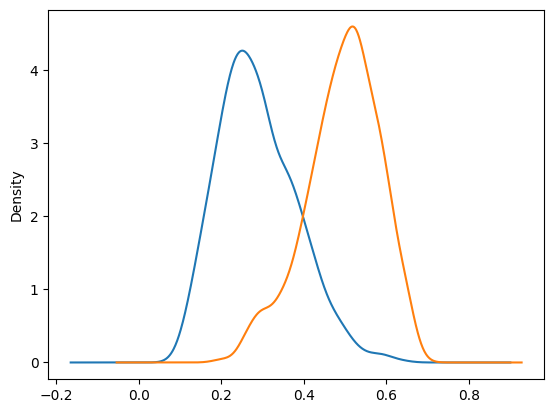

In [12]:
df[df.decision == "Yes"].distance.plot.kde()
df[df.decision == "No"].distance.plot.kde()

### Treshold calculation

In [13]:
sigma_2_threshold = round(tp_mean + 2 * tp_std, 4) # Corresponds to 95.45% confidence 
sigma_3_threshold = round(tp_mean + 3 * tp_std, 4) # Corresponds to 99.73% confidence
print(f"2 Sigma threshold: {sigma_2_threshold}")
print(f"3 Sigma threshold: {sigma_3_threshold}")

2 Sigma threshold: 0.4758
3 Sigma threshold: 0.5699


In [14]:
# Generate an output folder and a rules.py file containing the calculated threshold

config = {'algorithm': 'C4.5'}
tmp_df = df[['distance', 'decision']].rename(columns={"decision": "Decision"}).copy()
print(tmp_df)
model = chef.fit(df=tmp_df, config=config, target_label='decision')

      distance Decision
0     0.257302      Yes
1     0.354857      Yes
2     0.241663      Yes
3     0.342542      Yes
4     0.369604      Yes
...        ...      ...
1979  0.447445       No
1980  0.499839       No
1981  0.523423       No
1982  0.480616       No
1983  0.452189       No

[1984 rows x 2 columns]
[INFO]:  6 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  1.167001485824585  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  84.4758064516129 % on  1984  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[662, 234], [74, 1014]]
Precision:  73.8839 %, Recall:  89.9457 %, F1:  81.1275 %


In [15]:
decision_tree_threshold = 0.41731853239358435

### Verification

In [16]:
df["prediction"] = "No"

df.loc[df.distance <= decision_tree_threshold, 'decision_tree_prediction'] = 'Yes'
df.loc[df.distance <= sigma_2_threshold, 'sigma_2_prediction'] = 'Yes'
df.loc[df.distance <= sigma_3_threshold, 'sigma_3_prediction'] = 'Yes'
df.loc[df.distance > decision_tree_threshold, 'decision_tree_prediction'] = 'No'
df.loc[df.distance > sigma_2_threshold, 'sigma_2_prediction'] = 'No'
df.loc[df.distance > sigma_3_threshold, 'sigma_3_prediction'] = 'No'

df

,file_x,file_y,decision,distance,prediction,decision_tree_prediction,sigma_2_prediction,sigma_3_prediction
0,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\022_b497b92e.jpg,Yes,0.257302,No,Yes,Yes,Yes
1,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\037_62d00a09.jpg,Yes,0.354857,No,Yes,Yes,Yes
2,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\045_c560251e.jpg,Yes,0.241663,No,Yes,Yes,Yes
3,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\050_7c5b026c.jpg,Yes,0.342542,No,Yes,Yes,Yes
4,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\084_da751ddd.jpg,Yes,0.369604,No,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...
1979,Tom Hanks\097_0c9b7ced.jpg,Will Smith\046_6d5b1ed6.jpg,No,0.447445,No,No,Yes,Yes
1980,Tom Hanks\097_0c9b7ced.jpg,Will Smith\051_1f3aede9.jpg,No,0.499839,No,No,No,Yes
1981,Tom Hanks\097_0c9b7ced.jpg,Will Smith\053_8405b30f.jpg,No,0.523423,No,No,No,Yes
1982,Tom Hanks\097_0c9b7ced.jpg,Will Smith\072_4a17b7fb.jpg,No,0.480616,No,No,No,Yes


### Evaluation

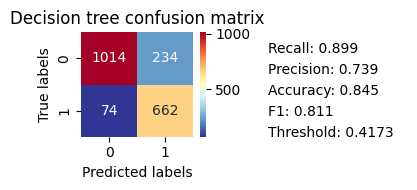

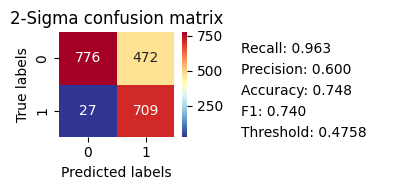

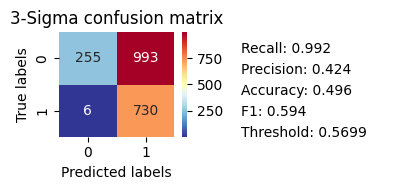

In [17]:
decision_tree_cm = confusion_matrix(df.decision.values, df.decision_tree_prediction.values)
sigma_2_cm = confusion_matrix(df.decision.values, df.sigma_2_prediction.values)
sigma_3_cm = confusion_matrix(df.decision.values, df.sigma_3_prediction.values)

def plot_cm_with_metrics(cm, title, threshold):
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    f1 = 2 * (precision * recall) / (precision + recall)

    plt.figure(figsize=(cm.shape[0] + 2, cm.shape[1]))
    plt.subplot(1, 2, 1)
    heatmap(cm, annot=True, fmt="d", cmap="RdYlBu_r")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.text(0, 0.8, f"Recall: {recall:.3f}", fontsize=10, ha='left')
    plt.text(0, 0.6, f"Precision: {precision:.3f}", fontsize=10, ha='left')
    plt.text(0, 0.4, f"Accuracy: {accuracy:.3f}", fontsize=10, ha='left')
    plt.text(0, 0.2, f"F1: {f1:.3f}", fontsize=10, ha='left')
    plt.text(0, 0, f"Threshold: {threshold:.4f}", fontsize=10, ha='left')

    plt.tight_layout()
    plt.show()

plot_cm_with_metrics(decision_tree_cm, "Decision tree confusion matrix", threshold=decision_tree_threshold)
plot_cm_with_metrics(sigma_2_cm, "2-Sigma confusion matrix", threshold=sigma_2_threshold)
plot_cm_with_metrics(sigma_3_cm, "3-Sigma confusion matrix", threshold=sigma_3_threshold)